a) Se define el discriminador de la GAN con 3 bloque convolucionales y una tanda fully conected, con los Dropout para evitar overfitting. Se utilizará la funcion de activación Leaky ReLU, para permitir que los gradientes fluyan hacia atrás a través de la capa sin obstáculos. Se trabajará con el dataset MNIST de keras y a continuación se presentará la arquitectura que conforma al modelo.

In [1]:
from keras.datasets import mnist
import numpy as np
import keras
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255.
X_test /= 255.
X_train = X_train.reshape(-1,28,28,1)
X_test = X_test.reshape(-1,28,28,1)
img_rows, img_cols,channel = X_train.shape[1:]

Using TensorFlow backend.


In [2]:
from keras.models import Model,Sequential
from keras.layers import LeakyReLU,Conv2D,Dropout,Flatten,Dense
## Discriminator
D = Sequential()
depth = 64
dropout = 0.4
input_shape = (img_rows, img_cols, channel)
D.add(Conv2D(depth*1, (5,5), strides=2, input_shape=input_shape,padding='same', activation=LeakyReLU(alpha=0.2)))
D.add(Dropout(dropout))
D.add(Conv2D(depth*2, (5,5), strides=2, padding='same',activation=LeakyReLU(alpha=0.2)))
D.add(Dropout(dropout))
D.add(Conv2D(depth*4, (5,5), strides=2, padding='same',activation=LeakyReLU(alpha=0.2)))
D.add(Dropout(dropout))
D.add(Flatten())
D.add(Dense(1024,activation=LeakyReLU(alpha=0.2)))
D.add(Dense(1,activation='sigmoid'))
D.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 256)         819456    
_________________________________________________________________
dropout_3 (Dropout)          (None, 4, 4, 256)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4096)              0         
__________

f:\python3.6\lib\site-packages\keras\activations.py:115: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


b) A continuación, definiremos el generador de la GAN, con una tanda fully conected y 3 bloque convolucionales transpuesta además de agregar BatchNormalization entre ellas para tener un aprendizaje más estable, cuya función de salida es sigmoidal, porque el output del generador debe variar entre 0 y 1.

In [3]:
from keras.layers import BatchNormalization,Reshape,UpSampling2D,Conv2DTranspose,Activation
## Generator
G = Sequential()
dim = 14
input_dim= 2 #para que sea similar al vAE
G.add(Dense(128, input_dim=input_dim))
G.add(BatchNormalization())
G.add(Activation('relu'))
G.add(Dense(dim*dim*depth))
G.add(BatchNormalization())
G.add(Activation('relu'))
G.add(Reshape((dim, dim, depth)))
G.add(Conv2DTranspose(int(depth/2), (3,3), padding='same',strides=(2,2)))
G.add(BatchNormalization())
G.add(Activation('relu'))
G.add(Conv2DTranspose(int(depth/2), (3,3), padding='same'))
G.add(BatchNormalization())
G.add(Activation('relu'))
G.add(Conv2DTranspose(channel, (3,3), padding='same')) 
G.add(Activation('sigmoid')) 
G.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 128)               384       
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
activation_1 (Activation)    (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 12544)             1618176   
_________________________________________________________________
batch_normalization_2 (Batch (None, 12544)             50176     
_________________________________________________________________
activation_2 (Activation)    (None, 12544)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 14, 14, 64)        0         
__________

c) Se conectan los modelos a través del enfoque adversario

In [4]:
from keras.optimizers import RMSprop
## Discriminator model (police)
optimizer = RMSprop(lr=0.0008, clipvalue=1.0, decay=6e-8)
DM = Sequential()
DM.add(D)
DM.compile(loss='binary_crossentropy', optimizer=optimizer,metrics=['accuracy'])
## Adversarial model (Generator->Discriminator)
D.trainable=False #set the discriminator freeze  (fixed params)
optimizer = RMSprop(lr=0.0004, clipvalue=1.0, decay=3e-8)
AM = Sequential()
AM.add(G)
AM.add(D)
AM.compile(loss='binary_crossentropy', optimizer=optimizer,metrics=['accuracy'])

d)Se entrena el modelo definido con un enfoque iterativo .

In [5]:
def train_on_steps(X_train,DM,AM,G,steps,batch_size):
    history = {"d":[],"g":[]}
    for e in range(train_steps):
        # Make generative images
        image_batch = X_train[np.random.randint(0,X_train.shape[0],size=batch_size),:,:,:] #sample images from real data
        noise_gen = np.random.uniform(-1,1,size=[batch_size,input_dim]) #sample image from generated data
        generated_images = G.predict(noise_gen) #fake images
        # Train discriminator on generated images
        X = np.concatenate((image_batch, generated_images))
        #create labels
        y = np.ones([2*batch_size,1])
        y[batch_size:,:] = 0
        d_loss  = DM.train_on_batch(X,y)
        history["d"].append(d_loss)
        # train Generator-Discriminator stack on input noise to non-generated output class
        noise_tr = np.random.uniform(-1,1,size=[batch_size,input_dim])
        y = np.ones([batch_size, 1])
        g_loss = AM.train_on_batch(noise_tr, y)
        history["g"].append(g_loss)
        log_mesg = "%d: [D loss: %f, acc: %f]" % (e, d_loss[0], d_loss[1])
        log_mesg = "%s  [G loss: %f, acc: %f]" % (log_mesg, g_loss[0], g_loss[1])
        print(log_mesg)
    return history
train_steps = 5000 #or few if  you want
hist = train_on_steps(X_train,DM,AM,G,train_steps,64)

f:\python3.6\lib\site-packages\keras\engine\training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0: [D loss: 0.691897, acc: 0.546875]  [G loss: 3.425355, acc: 0.000000]
1: [D loss: 0.655931, acc: 0.507812]  [G loss: 0.000006, acc: 1.000000]
2: [D loss: 6.191518, acc: 0.500000]  [G loss: 2.967941, acc: 0.000000]
3: [D loss: 1.760207, acc: 0.500000]  [G loss: 0.001039, acc: 1.000000]
4: [D loss: 3.907363, acc: 0.500000]  [G loss: 1.290272, acc: 0.000000]
5: [D loss: 0.427510, acc: 1.000000]  [G loss: 1.936907, acc: 0.000000]
6: [D loss: 0.333792, acc: 1.000000]  [G loss: 2.607687, acc: 0.000000]
7: [D loss: 0.290353, acc: 0.992188]  [G loss: 3.216900, acc: 0.000000]
8: [D loss: 0.238693, acc: 0.960938]  [G loss: 1.344268, acc: 0.078125]
9: [D loss: 0.386923, acc: 0.796875]  [G loss: 15.359627, acc: 0.000000]
10: [D loss: 4.181634, acc: 0.500000]  [G loss: 0.625612, acc: 0.765625]
11: [D loss: 0.430609, acc: 0.773438]  [G loss: 0.776045, acc: 0.437500]
12: [D loss: 0.327071, acc: 0.953125]  [G loss: 1.041419, acc: 0.046875]
13: [D loss: 0.274288, acc: 0.976562]  [G loss: 1.460608, ac

113: [D loss: 0.550192, acc: 0.648438]  [G loss: 0.180987, acc: 1.000000]
114: [D loss: 0.753819, acc: 0.500000]  [G loss: 0.663549, acc: 0.640625]
115: [D loss: 0.517217, acc: 0.835938]  [G loss: 1.010108, acc: 0.328125]
116: [D loss: 0.415675, acc: 0.843750]  [G loss: 0.598445, acc: 0.671875]
117: [D loss: 0.464178, acc: 0.804688]  [G loss: 1.435236, acc: 0.125000]
118: [D loss: 0.497502, acc: 0.718750]  [G loss: 0.156826, acc: 1.000000]
119: [D loss: 0.709271, acc: 0.500000]  [G loss: 0.939816, acc: 0.234375]
120: [D loss: 0.418204, acc: 0.875000]  [G loss: 1.116118, acc: 0.218750]
121: [D loss: 0.396671, acc: 0.875000]  [G loss: 0.702838, acc: 0.625000]
122: [D loss: 0.417975, acc: 0.796875]  [G loss: 3.252560, acc: 0.000000]
123: [D loss: 1.005889, acc: 0.570312]  [G loss: 0.130641, acc: 1.000000]
124: [D loss: 1.018844, acc: 0.500000]  [G loss: 0.684983, acc: 0.625000]
125: [D loss: 0.553821, acc: 0.726562]  [G loss: 0.765249, acc: 0.328125]
126: [D loss: 0.559296, acc: 0.695312]

224: [D loss: 0.508293, acc: 0.773438]  [G loss: 0.904369, acc: 0.359375]
225: [D loss: 0.486755, acc: 0.796875]  [G loss: 1.109941, acc: 0.265625]
226: [D loss: 0.567208, acc: 0.664062]  [G loss: 0.631458, acc: 0.640625]
227: [D loss: 0.496759, acc: 0.773438]  [G loss: 0.660797, acc: 0.625000]
228: [D loss: 0.492194, acc: 0.765625]  [G loss: 0.359497, acc: 0.937500]
229: [D loss: 0.450482, acc: 0.828125]  [G loss: 0.626853, acc: 0.640625]
230: [D loss: 0.516892, acc: 0.734375]  [G loss: 1.242214, acc: 0.312500]
231: [D loss: 0.448275, acc: 0.789062]  [G loss: 0.903965, acc: 0.421875]
232: [D loss: 0.445573, acc: 0.796875]  [G loss: 1.647591, acc: 0.078125]
233: [D loss: 0.422990, acc: 0.828125]  [G loss: 0.327416, acc: 0.906250]
234: [D loss: 0.578530, acc: 0.679688]  [G loss: 2.734689, acc: 0.015625]
235: [D loss: 0.739414, acc: 0.648438]  [G loss: 0.214846, acc: 0.984375]
236: [D loss: 0.691368, acc: 0.578125]  [G loss: 1.353676, acc: 0.109375]
237: [D loss: 0.451946, acc: 0.828125]

338: [D loss: 0.491110, acc: 0.765625]  [G loss: 1.143422, acc: 0.109375]
339: [D loss: 0.604163, acc: 0.648438]  [G loss: 0.931546, acc: 0.203125]
340: [D loss: 0.460077, acc: 0.781250]  [G loss: 0.980082, acc: 0.109375]
341: [D loss: 0.603076, acc: 0.640625]  [G loss: 1.233096, acc: 0.031250]
342: [D loss: 0.593001, acc: 0.617188]  [G loss: 0.632143, acc: 0.656250]
343: [D loss: 0.520263, acc: 0.648438]  [G loss: 0.856292, acc: 0.406250]
344: [D loss: 0.602455, acc: 0.687500]  [G loss: 0.569793, acc: 0.734375]
345: [D loss: 0.558145, acc: 0.656250]  [G loss: 1.285791, acc: 0.062500]
346: [D loss: 0.510728, acc: 0.742188]  [G loss: 0.595278, acc: 0.640625]
347: [D loss: 0.481748, acc: 0.695312]  [G loss: 1.429889, acc: 0.093750]
348: [D loss: 0.512731, acc: 0.781250]  [G loss: 0.738882, acc: 0.406250]
349: [D loss: 0.512278, acc: 0.710938]  [G loss: 0.838398, acc: 0.390625]
350: [D loss: 0.501695, acc: 0.726562]  [G loss: 0.966840, acc: 0.171875]
351: [D loss: 0.525868, acc: 0.718750]

449: [D loss: 0.344926, acc: 0.867188]  [G loss: 0.916441, acc: 0.359375]
450: [D loss: 0.500903, acc: 0.765625]  [G loss: 2.530519, acc: 0.000000]
451: [D loss: 0.751603, acc: 0.656250]  [G loss: 0.722240, acc: 0.515625]
452: [D loss: 0.740159, acc: 0.648438]  [G loss: 1.287654, acc: 0.031250]
453: [D loss: 0.510582, acc: 0.695312]  [G loss: 0.953362, acc: 0.125000]
454: [D loss: 0.482544, acc: 0.765625]  [G loss: 0.907216, acc: 0.218750]
455: [D loss: 0.388894, acc: 0.843750]  [G loss: 0.737583, acc: 0.406250]
456: [D loss: 0.336831, acc: 0.851562]  [G loss: 0.844965, acc: 0.390625]
457: [D loss: 0.404942, acc: 0.796875]  [G loss: 1.424140, acc: 0.078125]
458: [D loss: 0.455474, acc: 0.789062]  [G loss: 0.617892, acc: 0.625000]
459: [D loss: 0.425079, acc: 0.773438]  [G loss: 1.918388, acc: 0.000000]
460: [D loss: 0.316637, acc: 0.921875]  [G loss: 1.182790, acc: 0.125000]
461: [D loss: 0.370318, acc: 0.812500]  [G loss: 1.310867, acc: 0.093750]
462: [D loss: 0.455661, acc: 0.750000]

559: [D loss: 0.516314, acc: 0.726562]  [G loss: 1.760810, acc: 0.031250]
560: [D loss: 0.578035, acc: 0.710938]  [G loss: 0.203525, acc: 0.968750]
561: [D loss: 0.620316, acc: 0.648438]  [G loss: 1.780711, acc: 0.015625]
562: [D loss: 0.471225, acc: 0.765625]  [G loss: 0.934240, acc: 0.265625]
563: [D loss: 0.383100, acc: 0.859375]  [G loss: 0.853323, acc: 0.328125]
564: [D loss: 0.442161, acc: 0.781250]  [G loss: 1.067702, acc: 0.171875]
565: [D loss: 0.393748, acc: 0.789062]  [G loss: 1.005154, acc: 0.312500]
566: [D loss: 0.381804, acc: 0.828125]  [G loss: 1.060560, acc: 0.171875]
567: [D loss: 0.376589, acc: 0.859375]  [G loss: 0.668342, acc: 0.562500]
568: [D loss: 0.363943, acc: 0.820312]  [G loss: 1.210001, acc: 0.109375]
569: [D loss: 0.428414, acc: 0.765625]  [G loss: 0.310762, acc: 0.890625]
570: [D loss: 0.642724, acc: 0.656250]  [G loss: 1.506720, acc: 0.140625]
571: [D loss: 0.545101, acc: 0.687500]  [G loss: 0.560069, acc: 0.546875]
572: [D loss: 0.517357, acc: 0.734375]

670: [D loss: 0.432383, acc: 0.828125]  [G loss: 0.952747, acc: 0.359375]
671: [D loss: 0.404736, acc: 0.851562]  [G loss: 0.655668, acc: 0.531250]
672: [D loss: 0.461568, acc: 0.679688]  [G loss: 1.663814, acc: 0.109375]
673: [D loss: 0.496910, acc: 0.773438]  [G loss: 0.470320, acc: 0.734375]
674: [D loss: 0.560833, acc: 0.718750]  [G loss: 1.858227, acc: 0.031250]
675: [D loss: 0.534863, acc: 0.750000]  [G loss: 0.707856, acc: 0.593750]
676: [D loss: 0.423315, acc: 0.796875]  [G loss: 1.361702, acc: 0.093750]
677: [D loss: 0.334782, acc: 0.867188]  [G loss: 1.150959, acc: 0.171875]
678: [D loss: 0.425832, acc: 0.789062]  [G loss: 1.319023, acc: 0.171875]
679: [D loss: 0.380225, acc: 0.843750]  [G loss: 0.917648, acc: 0.265625]
680: [D loss: 0.423108, acc: 0.773438]  [G loss: 2.280898, acc: 0.031250]
681: [D loss: 0.385572, acc: 0.820312]  [G loss: 1.057933, acc: 0.328125]
682: [D loss: 0.476183, acc: 0.742188]  [G loss: 2.629891, acc: 0.000000]
683: [D loss: 0.606516, acc: 0.679688]

781: [D loss: 0.436791, acc: 0.820312]  [G loss: 1.018526, acc: 0.375000]
782: [D loss: 0.363789, acc: 0.820312]  [G loss: 1.866850, acc: 0.031250]
783: [D loss: 0.281425, acc: 0.875000]  [G loss: 0.832873, acc: 0.437500]
784: [D loss: 0.319013, acc: 0.851562]  [G loss: 1.130119, acc: 0.265625]
785: [D loss: 0.276277, acc: 0.875000]  [G loss: 0.829730, acc: 0.437500]
786: [D loss: 0.338467, acc: 0.843750]  [G loss: 0.837583, acc: 0.515625]
787: [D loss: 0.298180, acc: 0.875000]  [G loss: 1.495074, acc: 0.156250]
788: [D loss: 0.302946, acc: 0.859375]  [G loss: 0.329216, acc: 0.875000]
789: [D loss: 0.303498, acc: 0.851562]  [G loss: 1.878449, acc: 0.031250]
790: [D loss: 0.318980, acc: 0.867188]  [G loss: 0.577848, acc: 0.765625]
791: [D loss: 0.406419, acc: 0.781250]  [G loss: 2.657514, acc: 0.000000]
792: [D loss: 0.348889, acc: 0.828125]  [G loss: 0.926549, acc: 0.421875]
793: [D loss: 0.237213, acc: 0.914062]  [G loss: 1.308917, acc: 0.187500]
794: [D loss: 0.290664, acc: 0.890625]

893: [D loss: 0.399984, acc: 0.812500]  [G loss: 0.817004, acc: 0.484375]
894: [D loss: 0.466008, acc: 0.781250]  [G loss: 0.557857, acc: 0.625000]
895: [D loss: 0.407881, acc: 0.804688]  [G loss: 0.781653, acc: 0.453125]
896: [D loss: 0.517097, acc: 0.757812]  [G loss: 0.694129, acc: 0.531250]
897: [D loss: 0.454968, acc: 0.742188]  [G loss: 0.631061, acc: 0.656250]
898: [D loss: 0.508160, acc: 0.742188]  [G loss: 1.560223, acc: 0.125000]
899: [D loss: 0.516421, acc: 0.695312]  [G loss: 0.262399, acc: 0.906250]
900: [D loss: 0.487209, acc: 0.796875]  [G loss: 0.997883, acc: 0.250000]
901: [D loss: 0.432448, acc: 0.796875]  [G loss: 0.338305, acc: 0.828125]
902: [D loss: 0.392266, acc: 0.773438]  [G loss: 1.220462, acc: 0.296875]
903: [D loss: 0.485947, acc: 0.726562]  [G loss: 0.490808, acc: 0.750000]
904: [D loss: 0.403750, acc: 0.804688]  [G loss: 0.593426, acc: 0.656250]
905: [D loss: 0.412143, acc: 0.773438]  [G loss: 0.882518, acc: 0.375000]
906: [D loss: 0.386917, acc: 0.812500]

1005: [D loss: 0.630946, acc: 0.734375]  [G loss: 1.541859, acc: 0.140625]
1006: [D loss: 0.319561, acc: 0.851562]  [G loss: 0.765155, acc: 0.484375]
1007: [D loss: 0.331675, acc: 0.828125]  [G loss: 0.858156, acc: 0.421875]
1008: [D loss: 0.506486, acc: 0.726562]  [G loss: 1.097740, acc: 0.234375]
1009: [D loss: 0.382416, acc: 0.812500]  [G loss: 0.448207, acc: 0.765625]
1010: [D loss: 0.469425, acc: 0.773438]  [G loss: 1.095953, acc: 0.343750]
1011: [D loss: 0.322921, acc: 0.851562]  [G loss: 0.579511, acc: 0.687500]
1012: [D loss: 0.333833, acc: 0.867188]  [G loss: 0.718041, acc: 0.562500]
1013: [D loss: 0.506841, acc: 0.734375]  [G loss: 0.867866, acc: 0.453125]
1014: [D loss: 0.286911, acc: 0.875000]  [G loss: 0.584199, acc: 0.593750]
1015: [D loss: 0.321552, acc: 0.867188]  [G loss: 0.697020, acc: 0.625000]
1016: [D loss: 0.435938, acc: 0.781250]  [G loss: 0.581459, acc: 0.687500]
1017: [D loss: 0.265562, acc: 0.867188]  [G loss: 0.671773, acc: 0.593750]
1018: [D loss: 0.315962, 

1114: [D loss: 0.329616, acc: 0.843750]  [G loss: 1.053769, acc: 0.234375]
1115: [D loss: 0.320998, acc: 0.843750]  [G loss: 1.547784, acc: 0.093750]
1116: [D loss: 0.308455, acc: 0.875000]  [G loss: 0.779131, acc: 0.453125]
1117: [D loss: 0.439484, acc: 0.781250]  [G loss: 2.430920, acc: 0.000000]
1118: [D loss: 0.515221, acc: 0.734375]  [G loss: 0.655185, acc: 0.562500]
1119: [D loss: 0.402005, acc: 0.789062]  [G loss: 1.871939, acc: 0.000000]
1120: [D loss: 0.393333, acc: 0.789062]  [G loss: 0.708504, acc: 0.484375]
1121: [D loss: 0.439137, acc: 0.804688]  [G loss: 1.184146, acc: 0.171875]
1122: [D loss: 0.395894, acc: 0.851562]  [G loss: 0.951396, acc: 0.312500]
1123: [D loss: 0.326239, acc: 0.851562]  [G loss: 1.041196, acc: 0.265625]
1124: [D loss: 0.308673, acc: 0.851562]  [G loss: 1.370302, acc: 0.125000]
1125: [D loss: 0.347425, acc: 0.859375]  [G loss: 0.667807, acc: 0.640625]
1126: [D loss: 0.419518, acc: 0.804688]  [G loss: 2.194983, acc: 0.046875]
1127: [D loss: 0.591145, 

1225: [D loss: 0.434723, acc: 0.820312]  [G loss: 1.878247, acc: 0.125000]
1226: [D loss: 0.417198, acc: 0.820312]  [G loss: 0.745614, acc: 0.546875]
1227: [D loss: 0.394004, acc: 0.851562]  [G loss: 1.637929, acc: 0.093750]
1228: [D loss: 0.387086, acc: 0.835938]  [G loss: 0.709065, acc: 0.531250]
1229: [D loss: 0.451950, acc: 0.773438]  [G loss: 1.064738, acc: 0.390625]
1230: [D loss: 0.386291, acc: 0.843750]  [G loss: 0.891233, acc: 0.421875]
1231: [D loss: 0.356744, acc: 0.828125]  [G loss: 0.695963, acc: 0.531250]
1232: [D loss: 0.329123, acc: 0.851562]  [G loss: 1.344721, acc: 0.203125]
1233: [D loss: 0.397974, acc: 0.781250]  [G loss: 0.387026, acc: 0.828125]
1234: [D loss: 0.404793, acc: 0.828125]  [G loss: 1.355180, acc: 0.250000]
1235: [D loss: 0.231588, acc: 0.914062]  [G loss: 1.173547, acc: 0.328125]
1236: [D loss: 0.339887, acc: 0.859375]  [G loss: 0.761394, acc: 0.468750]
1237: [D loss: 0.376609, acc: 0.859375]  [G loss: 1.582219, acc: 0.171875]
1238: [D loss: 0.261305, 

1335: [D loss: 0.519934, acc: 0.742188]  [G loss: 0.485115, acc: 0.718750]
1336: [D loss: 0.464147, acc: 0.851562]  [G loss: 0.873652, acc: 0.421875]
1337: [D loss: 0.458779, acc: 0.796875]  [G loss: 0.877357, acc: 0.500000]
1338: [D loss: 0.380781, acc: 0.812500]  [G loss: 0.669820, acc: 0.625000]
1339: [D loss: 0.482500, acc: 0.781250]  [G loss: 1.059300, acc: 0.281250]
1340: [D loss: 0.386178, acc: 0.804688]  [G loss: 0.511191, acc: 0.687500]
1341: [D loss: 0.506892, acc: 0.703125]  [G loss: 1.512776, acc: 0.156250]
1342: [D loss: 0.444274, acc: 0.742188]  [G loss: 0.285560, acc: 0.875000]
1343: [D loss: 0.438324, acc: 0.773438]  [G loss: 1.081554, acc: 0.328125]
1344: [D loss: 0.447513, acc: 0.765625]  [G loss: 0.985574, acc: 0.250000]
1345: [D loss: 0.449501, acc: 0.773438]  [G loss: 0.562736, acc: 0.671875]
1346: [D loss: 0.534364, acc: 0.742188]  [G loss: 0.857449, acc: 0.390625]
1347: [D loss: 0.431106, acc: 0.796875]  [G loss: 0.561190, acc: 0.656250]
1348: [D loss: 0.494923, 

1445: [D loss: 0.385950, acc: 0.820312]  [G loss: 0.826414, acc: 0.531250]
1446: [D loss: 0.287764, acc: 0.875000]  [G loss: 0.670240, acc: 0.546875]
1447: [D loss: 0.359035, acc: 0.851562]  [G loss: 0.745492, acc: 0.640625]
1448: [D loss: 0.331297, acc: 0.843750]  [G loss: 1.562763, acc: 0.171875]
1449: [D loss: 0.312578, acc: 0.851562]  [G loss: 0.836155, acc: 0.562500]
1450: [D loss: 0.446230, acc: 0.796875]  [G loss: 1.698958, acc: 0.109375]
1451: [D loss: 0.363248, acc: 0.843750]  [G loss: 0.460229, acc: 0.765625]
1452: [D loss: 0.599167, acc: 0.734375]  [G loss: 1.758678, acc: 0.093750]
1453: [D loss: 0.414553, acc: 0.789062]  [G loss: 0.394427, acc: 0.812500]
1454: [D loss: 0.475815, acc: 0.718750]  [G loss: 1.541682, acc: 0.171875]
1455: [D loss: 0.477085, acc: 0.796875]  [G loss: 0.508690, acc: 0.734375]
1456: [D loss: 0.617589, acc: 0.718750]  [G loss: 1.277516, acc: 0.359375]
1457: [D loss: 0.354399, acc: 0.820312]  [G loss: 0.807246, acc: 0.515625]
1458: [D loss: 0.411672, 

1558: [D loss: 0.281684, acc: 0.882812]  [G loss: 1.847903, acc: 0.093750]
1559: [D loss: 0.440521, acc: 0.812500]  [G loss: 0.794156, acc: 0.484375]
1560: [D loss: 0.339699, acc: 0.828125]  [G loss: 0.971746, acc: 0.343750]
1561: [D loss: 0.304105, acc: 0.843750]  [G loss: 0.790399, acc: 0.531250]
1562: [D loss: 0.256769, acc: 0.914062]  [G loss: 0.947654, acc: 0.390625]
1563: [D loss: 0.359016, acc: 0.828125]  [G loss: 1.125169, acc: 0.343750]
1564: [D loss: 0.351985, acc: 0.875000]  [G loss: 0.399608, acc: 0.796875]
1565: [D loss: 0.376911, acc: 0.843750]  [G loss: 1.989765, acc: 0.015625]
1566: [D loss: 0.445049, acc: 0.750000]  [G loss: 0.634017, acc: 0.671875]
1567: [D loss: 0.365475, acc: 0.804688]  [G loss: 1.720049, acc: 0.093750]
1568: [D loss: 0.307217, acc: 0.851562]  [G loss: 0.721104, acc: 0.500000]
1569: [D loss: 0.279361, acc: 0.828125]  [G loss: 1.494375, acc: 0.156250]
1570: [D loss: 0.411828, acc: 0.789062]  [G loss: 0.651343, acc: 0.593750]
1571: [D loss: 0.288196, 

1668: [D loss: 0.348265, acc: 0.851562]  [G loss: 1.110600, acc: 0.234375]
1669: [D loss: 0.235181, acc: 0.890625]  [G loss: 0.360653, acc: 0.812500]
1670: [D loss: 0.465909, acc: 0.789062]  [G loss: 1.414019, acc: 0.156250]
1671: [D loss: 0.310002, acc: 0.859375]  [G loss: 0.530075, acc: 0.671875]
1672: [D loss: 0.427922, acc: 0.765625]  [G loss: 1.782041, acc: 0.031250]
1673: [D loss: 0.377528, acc: 0.843750]  [G loss: 0.644896, acc: 0.578125]
1674: [D loss: 0.313402, acc: 0.867188]  [G loss: 1.378433, acc: 0.250000]
1675: [D loss: 0.279771, acc: 0.921875]  [G loss: 0.952096, acc: 0.406250]
1676: [D loss: 0.271076, acc: 0.906250]  [G loss: 0.898728, acc: 0.421875]
1677: [D loss: 0.286678, acc: 0.867188]  [G loss: 0.463422, acc: 0.734375]
1678: [D loss: 0.278590, acc: 0.867188]  [G loss: 0.907746, acc: 0.453125]
1679: [D loss: 0.324628, acc: 0.867188]  [G loss: 0.690930, acc: 0.546875]
1680: [D loss: 0.284264, acc: 0.890625]  [G loss: 1.250323, acc: 0.343750]
1681: [D loss: 0.240165, 

1779: [D loss: 0.424575, acc: 0.773438]  [G loss: 1.389429, acc: 0.343750]
1780: [D loss: 0.346948, acc: 0.820312]  [G loss: 0.837547, acc: 0.562500]
1781: [D loss: 0.173323, acc: 0.937500]  [G loss: 0.465970, acc: 0.734375]
1782: [D loss: 0.456255, acc: 0.835938]  [G loss: 2.338911, acc: 0.015625]
1783: [D loss: 0.462042, acc: 0.750000]  [G loss: 0.638474, acc: 0.687500]
1784: [D loss: 0.394502, acc: 0.796875]  [G loss: 1.411474, acc: 0.171875]
1785: [D loss: 0.401950, acc: 0.789062]  [G loss: 0.600499, acc: 0.671875]
1786: [D loss: 0.347836, acc: 0.820312]  [G loss: 1.424842, acc: 0.140625]
1787: [D loss: 0.258511, acc: 0.851562]  [G loss: 0.392572, acc: 0.750000]
1788: [D loss: 0.603298, acc: 0.750000]  [G loss: 1.352403, acc: 0.187500]
1789: [D loss: 0.297178, acc: 0.859375]  [G loss: 0.750962, acc: 0.531250]
1790: [D loss: 0.349866, acc: 0.820312]  [G loss: 1.004341, acc: 0.328125]
1791: [D loss: 0.318626, acc: 0.820312]  [G loss: 0.760949, acc: 0.562500]
1792: [D loss: 0.266193, 

1890: [D loss: 0.266701, acc: 0.882812]  [G loss: 1.117346, acc: 0.359375]
1891: [D loss: 0.219992, acc: 0.859375]  [G loss: 0.285441, acc: 0.890625]
1892: [D loss: 0.286070, acc: 0.859375]  [G loss: 0.887635, acc: 0.421875]
1893: [D loss: 0.227909, acc: 0.890625]  [G loss: 0.434282, acc: 0.765625]
1894: [D loss: 0.359856, acc: 0.804688]  [G loss: 1.802941, acc: 0.109375]
1895: [D loss: 0.314232, acc: 0.835938]  [G loss: 0.418289, acc: 0.718750]
1896: [D loss: 0.649223, acc: 0.718750]  [G loss: 2.018674, acc: 0.031250]
1897: [D loss: 0.386976, acc: 0.828125]  [G loss: 1.260499, acc: 0.187500]
1898: [D loss: 0.305647, acc: 0.890625]  [G loss: 1.628143, acc: 0.046875]
1899: [D loss: 0.290838, acc: 0.867188]  [G loss: 1.227405, acc: 0.203125]
1900: [D loss: 0.179778, acc: 0.937500]  [G loss: 1.158190, acc: 0.234375]
1901: [D loss: 0.251194, acc: 0.882812]  [G loss: 0.873667, acc: 0.375000]
1902: [D loss: 0.246365, acc: 0.882812]  [G loss: 1.063005, acc: 0.390625]
1903: [D loss: 0.317550, 

2004: [D loss: 0.194810, acc: 0.921875]  [G loss: 0.972883, acc: 0.359375]
2005: [D loss: 0.226694, acc: 0.906250]  [G loss: 0.969099, acc: 0.328125]
2006: [D loss: 0.270192, acc: 0.875000]  [G loss: 1.332972, acc: 0.312500]
2007: [D loss: 0.227319, acc: 0.898438]  [G loss: 1.015739, acc: 0.406250]
2008: [D loss: 0.363500, acc: 0.804688]  [G loss: 1.302844, acc: 0.125000]
2009: [D loss: 0.246293, acc: 0.898438]  [G loss: 0.683500, acc: 0.515625]
2010: [D loss: 0.304560, acc: 0.882812]  [G loss: 1.415012, acc: 0.281250]
2011: [D loss: 0.262385, acc: 0.898438]  [G loss: 1.223898, acc: 0.296875]
2012: [D loss: 0.240693, acc: 0.882812]  [G loss: 0.950712, acc: 0.468750]
2013: [D loss: 0.324725, acc: 0.843750]  [G loss: 1.684333, acc: 0.234375]
2014: [D loss: 0.371954, acc: 0.867188]  [G loss: 1.717565, acc: 0.234375]
2015: [D loss: 0.499147, acc: 0.765625]  [G loss: 0.552804, acc: 0.703125]
2016: [D loss: 0.540728, acc: 0.742188]  [G loss: 2.232434, acc: 0.109375]
2017: [D loss: 0.524328, 

2113: [D loss: 0.348009, acc: 0.843750]  [G loss: 1.560971, acc: 0.265625]
2114: [D loss: 0.388952, acc: 0.789062]  [G loss: 0.819452, acc: 0.453125]
2115: [D loss: 0.355811, acc: 0.835938]  [G loss: 1.343122, acc: 0.265625]
2116: [D loss: 0.385171, acc: 0.843750]  [G loss: 0.478949, acc: 0.734375]
2117: [D loss: 0.464733, acc: 0.781250]  [G loss: 1.800141, acc: 0.156250]
2118: [D loss: 0.327751, acc: 0.851562]  [G loss: 0.696478, acc: 0.640625]
2119: [D loss: 0.423906, acc: 0.750000]  [G loss: 1.216564, acc: 0.343750]
2120: [D loss: 0.443420, acc: 0.750000]  [G loss: 0.788892, acc: 0.484375]
2121: [D loss: 0.322435, acc: 0.843750]  [G loss: 0.716889, acc: 0.500000]
2122: [D loss: 0.275339, acc: 0.875000]  [G loss: 0.620595, acc: 0.656250]
2123: [D loss: 0.442645, acc: 0.734375]  [G loss: 1.387887, acc: 0.156250]
2124: [D loss: 0.353281, acc: 0.820312]  [G loss: 0.813853, acc: 0.468750]
2125: [D loss: 0.365462, acc: 0.867188]  [G loss: 0.821233, acc: 0.453125]
2126: [D loss: 0.394658, 

2227: [D loss: 0.316376, acc: 0.867188]  [G loss: 1.088446, acc: 0.218750]
2228: [D loss: 0.281677, acc: 0.898438]  [G loss: 1.573759, acc: 0.125000]
2229: [D loss: 0.245669, acc: 0.898438]  [G loss: 1.108176, acc: 0.296875]
2230: [D loss: 0.293760, acc: 0.875000]  [G loss: 1.415675, acc: 0.328125]
2231: [D loss: 0.256732, acc: 0.890625]  [G loss: 0.985121, acc: 0.390625]
2232: [D loss: 0.365895, acc: 0.859375]  [G loss: 1.370335, acc: 0.218750]
2233: [D loss: 0.195288, acc: 0.921875]  [G loss: 0.927488, acc: 0.484375]
2234: [D loss: 0.382202, acc: 0.835938]  [G loss: 2.098498, acc: 0.078125]
2235: [D loss: 0.445181, acc: 0.820312]  [G loss: 0.576674, acc: 0.656250]
2236: [D loss: 0.414066, acc: 0.789062]  [G loss: 2.040434, acc: 0.093750]
2237: [D loss: 0.454138, acc: 0.804688]  [G loss: 0.613144, acc: 0.687500]
2238: [D loss: 0.437387, acc: 0.796875]  [G loss: 1.405615, acc: 0.281250]
2239: [D loss: 0.280059, acc: 0.875000]  [G loss: 0.646191, acc: 0.671875]
2240: [D loss: 0.340937, 

2337: [D loss: 0.281426, acc: 0.859375]  [G loss: 1.047081, acc: 0.375000]
2338: [D loss: 0.275325, acc: 0.890625]  [G loss: 2.011240, acc: 0.093750]
2339: [D loss: 0.266387, acc: 0.875000]  [G loss: 1.234022, acc: 0.250000]
2340: [D loss: 0.253546, acc: 0.882812]  [G loss: 1.822559, acc: 0.156250]
2341: [D loss: 0.288124, acc: 0.875000]  [G loss: 0.783753, acc: 0.515625]
2342: [D loss: 0.485719, acc: 0.804688]  [G loss: 2.021690, acc: 0.062500]
2343: [D loss: 0.403225, acc: 0.820312]  [G loss: 0.623024, acc: 0.640625]
2344: [D loss: 0.346292, acc: 0.835938]  [G loss: 2.036626, acc: 0.046875]
2345: [D loss: 0.229272, acc: 0.890625]  [G loss: 1.050478, acc: 0.390625]
2346: [D loss: 0.352167, acc: 0.843750]  [G loss: 1.141594, acc: 0.390625]
2347: [D loss: 0.299557, acc: 0.859375]  [G loss: 0.886529, acc: 0.453125]
2348: [D loss: 0.234309, acc: 0.890625]  [G loss: 1.374203, acc: 0.343750]
2349: [D loss: 0.273111, acc: 0.898438]  [G loss: 0.619045, acc: 0.609375]
2350: [D loss: 0.371236, 

2449: [D loss: 0.351478, acc: 0.851562]  [G loss: 0.827358, acc: 0.453125]
2450: [D loss: 0.451795, acc: 0.773438]  [G loss: 0.787829, acc: 0.546875]
2451: [D loss: 0.318899, acc: 0.851562]  [G loss: 0.709665, acc: 0.625000]
2452: [D loss: 0.420582, acc: 0.812500]  [G loss: 0.592488, acc: 0.656250]
2453: [D loss: 0.400331, acc: 0.765625]  [G loss: 1.031092, acc: 0.312500]
2454: [D loss: 0.327017, acc: 0.867188]  [G loss: 0.763945, acc: 0.546875]
2455: [D loss: 0.294673, acc: 0.867188]  [G loss: 0.860084, acc: 0.578125]
2456: [D loss: 0.289806, acc: 0.882812]  [G loss: 1.052786, acc: 0.390625]
2457: [D loss: 0.369563, acc: 0.796875]  [G loss: 0.298888, acc: 0.890625]
2458: [D loss: 0.265844, acc: 0.867188]  [G loss: 0.890090, acc: 0.468750]
2459: [D loss: 0.305321, acc: 0.882812]  [G loss: 1.387976, acc: 0.187500]
2460: [D loss: 0.319616, acc: 0.835938]  [G loss: 0.455229, acc: 0.750000]
2461: [D loss: 0.337750, acc: 0.835938]  [G loss: 1.565785, acc: 0.156250]
2462: [D loss: 0.284071, 

2561: [D loss: 0.331744, acc: 0.851562]  [G loss: 1.799893, acc: 0.187500]
2562: [D loss: 0.305699, acc: 0.851562]  [G loss: 0.762013, acc: 0.578125]
2563: [D loss: 0.260959, acc: 0.890625]  [G loss: 1.544773, acc: 0.187500]
2564: [D loss: 0.280567, acc: 0.851562]  [G loss: 1.136670, acc: 0.515625]
2565: [D loss: 0.302095, acc: 0.867188]  [G loss: 1.315529, acc: 0.250000]
2566: [D loss: 0.292627, acc: 0.859375]  [G loss: 1.058949, acc: 0.500000]
2567: [D loss: 0.259886, acc: 0.890625]  [G loss: 1.118218, acc: 0.343750]
2568: [D loss: 0.231191, acc: 0.906250]  [G loss: 0.901667, acc: 0.484375]
2569: [D loss: 0.296080, acc: 0.875000]  [G loss: 1.272406, acc: 0.437500]
2570: [D loss: 0.269296, acc: 0.875000]  [G loss: 0.589262, acc: 0.687500]
2571: [D loss: 0.495322, acc: 0.789062]  [G loss: 3.271682, acc: 0.000000]
2572: [D loss: 0.645555, acc: 0.734375]  [G loss: 0.348033, acc: 0.843750]
2573: [D loss: 0.751990, acc: 0.695312]  [G loss: 1.423499, acc: 0.343750]
2574: [D loss: 0.415377, 

2672: [D loss: 0.303513, acc: 0.867188]  [G loss: 0.494631, acc: 0.796875]
2673: [D loss: 0.339877, acc: 0.851562]  [G loss: 1.005543, acc: 0.484375]
2674: [D loss: 0.255669, acc: 0.867188]  [G loss: 0.524883, acc: 0.703125]
2675: [D loss: 0.315461, acc: 0.828125]  [G loss: 1.031510, acc: 0.453125]
2676: [D loss: 0.332891, acc: 0.859375]  [G loss: 0.618813, acc: 0.671875]
2677: [D loss: 0.273163, acc: 0.867188]  [G loss: 1.968487, acc: 0.125000]
2678: [D loss: 0.413050, acc: 0.796875]  [G loss: 0.196810, acc: 0.906250]
2679: [D loss: 0.516561, acc: 0.773438]  [G loss: 2.029505, acc: 0.171875]
2680: [D loss: 0.371413, acc: 0.820312]  [G loss: 1.162864, acc: 0.359375]
2681: [D loss: 0.286243, acc: 0.851562]  [G loss: 0.766792, acc: 0.546875]
2682: [D loss: 0.254350, acc: 0.898438]  [G loss: 1.314267, acc: 0.296875]
2683: [D loss: 0.244795, acc: 0.914062]  [G loss: 0.713419, acc: 0.671875]
2684: [D loss: 0.178472, acc: 0.937500]  [G loss: 0.628732, acc: 0.640625]
2685: [D loss: 0.150364, 

2784: [D loss: 0.323521, acc: 0.859375]  [G loss: 0.755865, acc: 0.562500]
2785: [D loss: 0.372985, acc: 0.804688]  [G loss: 0.996347, acc: 0.484375]
2786: [D loss: 0.294376, acc: 0.882812]  [G loss: 1.100091, acc: 0.375000]
2787: [D loss: 0.352345, acc: 0.796875]  [G loss: 0.869714, acc: 0.546875]
2788: [D loss: 0.259830, acc: 0.914062]  [G loss: 0.722012, acc: 0.546875]
2789: [D loss: 0.366474, acc: 0.835938]  [G loss: 0.941072, acc: 0.500000]
2790: [D loss: 0.322111, acc: 0.820312]  [G loss: 0.527675, acc: 0.687500]
2791: [D loss: 0.310064, acc: 0.851562]  [G loss: 1.644014, acc: 0.234375]
2792: [D loss: 0.281127, acc: 0.859375]  [G loss: 0.403210, acc: 0.781250]
2793: [D loss: 0.364029, acc: 0.828125]  [G loss: 1.110253, acc: 0.453125]
2794: [D loss: 0.238164, acc: 0.898438]  [G loss: 0.425045, acc: 0.765625]
2795: [D loss: 0.326723, acc: 0.843750]  [G loss: 1.108270, acc: 0.343750]
2796: [D loss: 0.311940, acc: 0.867188]  [G loss: 1.037648, acc: 0.437500]
2797: [D loss: 0.366414, 

2896: [D loss: 0.184045, acc: 0.914062]  [G loss: 1.512444, acc: 0.218750]
2897: [D loss: 0.248853, acc: 0.882812]  [G loss: 0.624978, acc: 0.718750]
2898: [D loss: 0.306505, acc: 0.867188]  [G loss: 2.894498, acc: 0.031250]
2899: [D loss: 0.282337, acc: 0.890625]  [G loss: 1.044167, acc: 0.359375]
2900: [D loss: 0.207366, acc: 0.937500]  [G loss: 1.364145, acc: 0.281250]
2901: [D loss: 0.271539, acc: 0.898438]  [G loss: 1.514406, acc: 0.375000]
2902: [D loss: 0.175803, acc: 0.929688]  [G loss: 1.109182, acc: 0.437500]
2903: [D loss: 0.178962, acc: 0.929688]  [G loss: 1.370847, acc: 0.312500]
2904: [D loss: 0.151824, acc: 0.937500]  [G loss: 0.829585, acc: 0.562500]
2905: [D loss: 0.209655, acc: 0.914062]  [G loss: 1.412622, acc: 0.437500]
2906: [D loss: 0.294093, acc: 0.906250]  [G loss: 0.903917, acc: 0.515625]
2907: [D loss: 0.204278, acc: 0.898438]  [G loss: 0.781121, acc: 0.609375]
2908: [D loss: 0.270733, acc: 0.906250]  [G loss: 2.177328, acc: 0.203125]
2909: [D loss: 0.449483, 

3007: [D loss: 0.335771, acc: 0.843750]  [G loss: 0.545968, acc: 0.703125]
3008: [D loss: 0.271971, acc: 0.882812]  [G loss: 1.097103, acc: 0.468750]
3009: [D loss: 0.248768, acc: 0.875000]  [G loss: 0.434891, acc: 0.750000]
3010: [D loss: 0.451964, acc: 0.765625]  [G loss: 1.574624, acc: 0.421875]
3011: [D loss: 0.332344, acc: 0.828125]  [G loss: 0.364789, acc: 0.796875]
3012: [D loss: 0.284246, acc: 0.867188]  [G loss: 0.807674, acc: 0.625000]
3013: [D loss: 0.301883, acc: 0.875000]  [G loss: 0.505328, acc: 0.703125]
3014: [D loss: 0.260502, acc: 0.890625]  [G loss: 0.670918, acc: 0.609375]
3015: [D loss: 0.253462, acc: 0.898438]  [G loss: 0.465382, acc: 0.718750]
3016: [D loss: 0.213423, acc: 0.906250]  [G loss: 0.536001, acc: 0.671875]
3017: [D loss: 0.336924, acc: 0.820312]  [G loss: 1.339409, acc: 0.421875]
3018: [D loss: 0.303892, acc: 0.843750]  [G loss: 0.296084, acc: 0.906250]
3019: [D loss: 0.197410, acc: 0.945312]  [G loss: 0.847324, acc: 0.531250]
3020: [D loss: 0.198975, 

3120: [D loss: 0.492200, acc: 0.796875]  [G loss: 1.773507, acc: 0.187500]
3121: [D loss: 0.415404, acc: 0.867188]  [G loss: 0.991815, acc: 0.421875]
3122: [D loss: 0.309105, acc: 0.882812]  [G loss: 0.515142, acc: 0.718750]
3123: [D loss: 0.369952, acc: 0.820312]  [G loss: 0.743574, acc: 0.562500]
3124: [D loss: 0.226658, acc: 0.906250]  [G loss: 0.573892, acc: 0.656250]
3125: [D loss: 0.209384, acc: 0.929688]  [G loss: 0.421527, acc: 0.781250]
3126: [D loss: 0.225452, acc: 0.906250]  [G loss: 0.766738, acc: 0.593750]
3127: [D loss: 0.270819, acc: 0.898438]  [G loss: 0.659461, acc: 0.671875]
3128: [D loss: 0.278055, acc: 0.875000]  [G loss: 0.831381, acc: 0.562500]
3129: [D loss: 0.330778, acc: 0.851562]  [G loss: 0.477139, acc: 0.765625]
3130: [D loss: 0.269222, acc: 0.867188]  [G loss: 1.112069, acc: 0.437500]
3131: [D loss: 0.247307, acc: 0.898438]  [G loss: 0.473414, acc: 0.718750]
3132: [D loss: 0.363120, acc: 0.828125]  [G loss: 1.455849, acc: 0.296875]
3133: [D loss: 0.271025, 

3232: [D loss: 0.225880, acc: 0.937500]  [G loss: 1.180112, acc: 0.546875]
3233: [D loss: 0.175235, acc: 0.929688]  [G loss: 0.355976, acc: 0.828125]
3234: [D loss: 0.267342, acc: 0.882812]  [G loss: 4.246399, acc: 0.031250]
3235: [D loss: 0.622373, acc: 0.781250]  [G loss: 0.336315, acc: 0.812500]
3236: [D loss: 0.507060, acc: 0.781250]  [G loss: 2.237120, acc: 0.250000]
3237: [D loss: 0.230228, acc: 0.882812]  [G loss: 1.044249, acc: 0.468750]
3238: [D loss: 0.198813, acc: 0.921875]  [G loss: 0.951624, acc: 0.562500]
3239: [D loss: 0.140343, acc: 0.953125]  [G loss: 0.932342, acc: 0.546875]
3240: [D loss: 0.175056, acc: 0.921875]  [G loss: 0.959071, acc: 0.593750]
3241: [D loss: 0.167217, acc: 0.945312]  [G loss: 0.468392, acc: 0.750000]
3242: [D loss: 0.210454, acc: 0.921875]  [G loss: 1.730089, acc: 0.437500]
3243: [D loss: 0.291767, acc: 0.867188]  [G loss: 0.251331, acc: 0.875000]
3244: [D loss: 0.251090, acc: 0.875000]  [G loss: 1.274315, acc: 0.375000]
3245: [D loss: 0.228494, 

3344: [D loss: 0.185121, acc: 0.929688]  [G loss: 0.923853, acc: 0.515625]
3345: [D loss: 0.251408, acc: 0.882812]  [G loss: 0.393316, acc: 0.812500]
3346: [D loss: 0.260179, acc: 0.890625]  [G loss: 1.591883, acc: 0.312500]
3347: [D loss: 0.261478, acc: 0.906250]  [G loss: 0.209775, acc: 0.906250]
3348: [D loss: 0.278104, acc: 0.898438]  [G loss: 2.207683, acc: 0.328125]
3349: [D loss: 0.182739, acc: 0.945312]  [G loss: 0.651541, acc: 0.625000]
3350: [D loss: 0.199839, acc: 0.921875]  [G loss: 0.256431, acc: 0.843750]
3351: [D loss: 0.299819, acc: 0.867188]  [G loss: 1.351374, acc: 0.453125]
3352: [D loss: 0.352214, acc: 0.843750]  [G loss: 1.339660, acc: 0.406250]
3353: [D loss: 0.240337, acc: 0.914062]  [G loss: 0.529672, acc: 0.703125]
3354: [D loss: 0.293005, acc: 0.898438]  [G loss: 0.676457, acc: 0.578125]
3355: [D loss: 0.306602, acc: 0.882812]  [G loss: 1.046912, acc: 0.453125]
3356: [D loss: 0.253314, acc: 0.875000]  [G loss: 1.111500, acc: 0.453125]
3357: [D loss: 0.171006, 

3457: [D loss: 0.138893, acc: 0.945312]  [G loss: 0.684198, acc: 0.609375]
3458: [D loss: 0.175092, acc: 0.937500]  [G loss: 1.535200, acc: 0.250000]
3459: [D loss: 0.141732, acc: 0.929688]  [G loss: 1.805126, acc: 0.250000]
3460: [D loss: 0.203001, acc: 0.921875]  [G loss: 0.619300, acc: 0.718750]
3461: [D loss: 0.680042, acc: 0.804688]  [G loss: 3.174192, acc: 0.125000]
3462: [D loss: 0.461916, acc: 0.835938]  [G loss: 1.063909, acc: 0.500000]
3463: [D loss: 0.258367, acc: 0.898438]  [G loss: 1.488761, acc: 0.218750]
3464: [D loss: 0.167060, acc: 0.929688]  [G loss: 0.581542, acc: 0.671875]
3465: [D loss: 0.120015, acc: 0.960938]  [G loss: 0.830440, acc: 0.500000]
3466: [D loss: 0.117080, acc: 0.968750]  [G loss: 0.752949, acc: 0.593750]
3467: [D loss: 0.127703, acc: 0.960938]  [G loss: 1.196972, acc: 0.328125]
3468: [D loss: 0.130489, acc: 0.945312]  [G loss: 0.401569, acc: 0.796875]
3469: [D loss: 0.078596, acc: 0.992188]  [G loss: 1.050230, acc: 0.562500]
3470: [D loss: 0.083536, 

3570: [D loss: 0.156261, acc: 0.960938]  [G loss: 0.696172, acc: 0.640625]
3571: [D loss: 0.089432, acc: 0.968750]  [G loss: 0.499973, acc: 0.765625]
3572: [D loss: 0.152025, acc: 0.945312]  [G loss: 1.722854, acc: 0.250000]
3573: [D loss: 0.154934, acc: 0.945312]  [G loss: 0.283383, acc: 0.906250]
3574: [D loss: 0.105188, acc: 0.953125]  [G loss: 0.667555, acc: 0.593750]
3575: [D loss: 0.204917, acc: 0.914062]  [G loss: 0.268225, acc: 0.921875]
3576: [D loss: 0.134778, acc: 0.945312]  [G loss: 0.620812, acc: 0.656250]
3577: [D loss: 0.097276, acc: 0.960938]  [G loss: 0.177562, acc: 0.921875]
3578: [D loss: 0.125843, acc: 0.937500]  [G loss: 0.214291, acc: 0.937500]
3579: [D loss: 0.122614, acc: 0.960938]  [G loss: 0.580467, acc: 0.671875]
3580: [D loss: 0.110504, acc: 0.937500]  [G loss: 0.424304, acc: 0.796875]
3581: [D loss: 0.082920, acc: 0.976562]  [G loss: 0.566344, acc: 0.718750]
3582: [D loss: 0.091649, acc: 0.968750]  [G loss: 0.269114, acc: 0.859375]
3583: [D loss: 0.443552, 

3681: [D loss: 0.224673, acc: 0.875000]  [G loss: 1.261881, acc: 0.390625]
3682: [D loss: 0.124485, acc: 0.953125]  [G loss: 1.374039, acc: 0.328125]
3683: [D loss: 0.230898, acc: 0.921875]  [G loss: 0.329491, acc: 0.796875]
3684: [D loss: 0.260219, acc: 0.914062]  [G loss: 2.114803, acc: 0.250000]
3685: [D loss: 0.312341, acc: 0.875000]  [G loss: 0.254400, acc: 0.875000]
3686: [D loss: 0.385652, acc: 0.867188]  [G loss: 1.484702, acc: 0.359375]
3687: [D loss: 0.172707, acc: 0.937500]  [G loss: 0.968487, acc: 0.562500]
3688: [D loss: 0.269951, acc: 0.890625]  [G loss: 0.609892, acc: 0.671875]
3689: [D loss: 0.232664, acc: 0.875000]  [G loss: 1.299094, acc: 0.531250]
3690: [D loss: 0.237005, acc: 0.914062]  [G loss: 0.362323, acc: 0.843750]
3691: [D loss: 0.185378, acc: 0.945312]  [G loss: 1.311746, acc: 0.375000]
3692: [D loss: 0.281606, acc: 0.875000]  [G loss: 0.667181, acc: 0.703125]
3693: [D loss: 0.157633, acc: 0.937500]  [G loss: 0.878922, acc: 0.609375]
3694: [D loss: 0.140171, 

3791: [D loss: 0.501876, acc: 0.859375]  [G loss: 1.505426, acc: 0.406250]
3792: [D loss: 0.223660, acc: 0.914062]  [G loss: 0.453562, acc: 0.812500]
3793: [D loss: 0.137099, acc: 0.953125]  [G loss: 0.272592, acc: 0.890625]
3794: [D loss: 0.151390, acc: 0.945312]  [G loss: 0.339932, acc: 0.812500]
3795: [D loss: 0.374462, acc: 0.835938]  [G loss: 1.085903, acc: 0.484375]
3796: [D loss: 0.372554, acc: 0.851562]  [G loss: 0.122482, acc: 0.953125]
3797: [D loss: 0.320193, acc: 0.875000]  [G loss: 1.072317, acc: 0.484375]
3798: [D loss: 0.249284, acc: 0.898438]  [G loss: 0.245375, acc: 0.828125]
3799: [D loss: 0.266033, acc: 0.914062]  [G loss: 0.507927, acc: 0.718750]
3800: [D loss: 0.160796, acc: 0.937500]  [G loss: 0.428582, acc: 0.765625]
3801: [D loss: 0.158314, acc: 0.929688]  [G loss: 0.439417, acc: 0.765625]
3802: [D loss: 0.114032, acc: 0.945312]  [G loss: 0.535091, acc: 0.750000]
3803: [D loss: 0.198428, acc: 0.898438]  [G loss: 0.643302, acc: 0.687500]
3804: [D loss: 0.239117, 

3903: [D loss: 0.404088, acc: 0.851562]  [G loss: 0.227987, acc: 0.890625]
3904: [D loss: 0.266169, acc: 0.875000]  [G loss: 1.658517, acc: 0.312500]
3905: [D loss: 0.223432, acc: 0.906250]  [G loss: 0.355068, acc: 0.781250]
3906: [D loss: 0.129439, acc: 0.953125]  [G loss: 0.581304, acc: 0.703125]
3907: [D loss: 0.145351, acc: 0.937500]  [G loss: 0.353620, acc: 0.843750]
3908: [D loss: 0.179214, acc: 0.929688]  [G loss: 0.889194, acc: 0.671875]
3909: [D loss: 0.151301, acc: 0.929688]  [G loss: 1.059886, acc: 0.562500]
3910: [D loss: 0.285474, acc: 0.851562]  [G loss: 0.948242, acc: 0.593750]
3911: [D loss: 0.129619, acc: 0.953125]  [G loss: 0.571412, acc: 0.703125]
3912: [D loss: 0.169512, acc: 0.921875]  [G loss: 0.538338, acc: 0.750000]
3913: [D loss: 0.142781, acc: 0.945312]  [G loss: 0.643816, acc: 0.687500]
3914: [D loss: 0.244429, acc: 0.882812]  [G loss: 0.538459, acc: 0.734375]
3915: [D loss: 0.189404, acc: 0.921875]  [G loss: 1.515925, acc: 0.375000]
3916: [D loss: 0.186829, 

4014: [D loss: 0.148046, acc: 0.914062]  [G loss: 1.029467, acc: 0.593750]
4015: [D loss: 0.213485, acc: 0.937500]  [G loss: 0.441163, acc: 0.781250]
4016: [D loss: 0.169449, acc: 0.914062]  [G loss: 0.449962, acc: 0.750000]
4017: [D loss: 0.123093, acc: 0.937500]  [G loss: 0.281324, acc: 0.843750]
4018: [D loss: 0.158495, acc: 0.937500]  [G loss: 1.220670, acc: 0.375000]
4019: [D loss: 0.177581, acc: 0.937500]  [G loss: 0.105803, acc: 0.953125]
4020: [D loss: 0.063968, acc: 0.984375]  [G loss: 0.063007, acc: 1.000000]
4021: [D loss: 0.052965, acc: 0.984375]  [G loss: 0.080219, acc: 0.953125]
4022: [D loss: 0.085380, acc: 0.968750]  [G loss: 0.295340, acc: 0.843750]
4023: [D loss: 0.135076, acc: 0.953125]  [G loss: 0.088778, acc: 0.968750]
4024: [D loss: 0.187725, acc: 0.914062]  [G loss: 0.352993, acc: 0.812500]
4025: [D loss: 0.068070, acc: 0.968750]  [G loss: 0.051769, acc: 0.984375]
4026: [D loss: 0.191255, acc: 0.921875]  [G loss: 2.922492, acc: 0.234375]
4027: [D loss: 0.180613, 

4125: [D loss: 0.340043, acc: 0.851562]  [G loss: 0.196892, acc: 0.875000]
4126: [D loss: 0.308129, acc: 0.859375]  [G loss: 0.884308, acc: 0.609375]
4127: [D loss: 0.194078, acc: 0.906250]  [G loss: 0.217155, acc: 0.875000]
4128: [D loss: 0.144548, acc: 0.929688]  [G loss: 0.882780, acc: 0.484375]
4129: [D loss: 0.241372, acc: 0.898438]  [G loss: 0.459929, acc: 0.765625]
4130: [D loss: 0.122078, acc: 0.945312]  [G loss: 0.233125, acc: 0.843750]
4131: [D loss: 0.244210, acc: 0.898438]  [G loss: 2.845811, acc: 0.062500]
4132: [D loss: 0.218206, acc: 0.906250]  [G loss: 0.592868, acc: 0.671875]
4133: [D loss: 0.176461, acc: 0.914062]  [G loss: 0.296341, acc: 0.796875]
4134: [D loss: 0.257647, acc: 0.898438]  [G loss: 1.999052, acc: 0.171875]
4135: [D loss: 0.208093, acc: 0.929688]  [G loss: 0.384173, acc: 0.828125]
4136: [D loss: 0.153521, acc: 0.937500]  [G loss: 0.232571, acc: 0.906250]
4137: [D loss: 0.062417, acc: 0.976562]  [G loss: 0.144402, acc: 0.937500]
4138: [D loss: 0.141711, 

4234: [D loss: 0.081927, acc: 0.968750]  [G loss: 0.983089, acc: 0.515625]
4235: [D loss: 0.186070, acc: 0.929688]  [G loss: 0.980364, acc: 0.546875]
4236: [D loss: 0.159843, acc: 0.914062]  [G loss: 0.105982, acc: 0.968750]
4237: [D loss: 0.139918, acc: 0.929688]  [G loss: 0.953976, acc: 0.546875]
4238: [D loss: 0.070352, acc: 0.968750]  [G loss: 0.717653, acc: 0.625000]
4239: [D loss: 0.127289, acc: 0.945312]  [G loss: 0.821476, acc: 0.671875]
4240: [D loss: 0.049156, acc: 0.984375]  [G loss: 0.845100, acc: 0.703125]
4241: [D loss: 0.072063, acc: 0.968750]  [G loss: 0.336850, acc: 0.828125]
4242: [D loss: 0.107532, acc: 0.937500]  [G loss: 1.067199, acc: 0.515625]
4243: [D loss: 0.106236, acc: 0.945312]  [G loss: 0.239156, acc: 0.875000]
4244: [D loss: 0.195027, acc: 0.929688]  [G loss: 2.765634, acc: 0.390625]
4245: [D loss: 0.107348, acc: 0.960938]  [G loss: 0.492879, acc: 0.812500]
4246: [D loss: 0.059645, acc: 0.976562]  [G loss: 0.489367, acc: 0.687500]
4247: [D loss: 0.166828, 

4346: [D loss: 0.292601, acc: 0.882812]  [G loss: 0.172020, acc: 0.906250]
4347: [D loss: 0.259441, acc: 0.875000]  [G loss: 1.545052, acc: 0.500000]
4348: [D loss: 0.130313, acc: 0.937500]  [G loss: 0.445292, acc: 0.750000]
4349: [D loss: 0.163805, acc: 0.953125]  [G loss: 0.560851, acc: 0.750000]
4350: [D loss: 0.110984, acc: 0.960938]  [G loss: 0.589195, acc: 0.687500]
4351: [D loss: 0.165438, acc: 0.937500]  [G loss: 0.130331, acc: 0.968750]
4352: [D loss: 0.154355, acc: 0.921875]  [G loss: 2.028227, acc: 0.218750]
4353: [D loss: 0.136620, acc: 0.953125]  [G loss: 0.421598, acc: 0.765625]
4354: [D loss: 0.150236, acc: 0.929688]  [G loss: 0.576446, acc: 0.750000]
4355: [D loss: 0.244394, acc: 0.945312]  [G loss: 0.510079, acc: 0.796875]
4356: [D loss: 0.051707, acc: 0.976562]  [G loss: 0.231498, acc: 0.890625]
4357: [D loss: 0.044619, acc: 0.992188]  [G loss: 0.507507, acc: 0.812500]
4358: [D loss: 0.161668, acc: 0.929688]  [G loss: 0.656106, acc: 0.703125]
4359: [D loss: 0.113557, 

4456: [D loss: 0.176573, acc: 0.937500]  [G loss: 0.542431, acc: 0.781250]
4457: [D loss: 0.122736, acc: 0.976562]  [G loss: 0.649825, acc: 0.703125]
4458: [D loss: 0.157398, acc: 0.937500]  [G loss: 0.328165, acc: 0.796875]
4459: [D loss: 0.180852, acc: 0.914062]  [G loss: 0.767163, acc: 0.609375]
4460: [D loss: 0.144545, acc: 0.960938]  [G loss: 0.465088, acc: 0.812500]
4461: [D loss: 0.217327, acc: 0.890625]  [G loss: 1.708748, acc: 0.437500]
4462: [D loss: 0.212256, acc: 0.906250]  [G loss: 0.393460, acc: 0.796875]
4463: [D loss: 0.280154, acc: 0.851562]  [G loss: 1.108575, acc: 0.515625]
4464: [D loss: 0.291260, acc: 0.859375]  [G loss: 0.241625, acc: 0.875000]
4465: [D loss: 0.240902, acc: 0.859375]  [G loss: 1.316453, acc: 0.390625]
4466: [D loss: 0.226840, acc: 0.906250]  [G loss: 0.329066, acc: 0.875000]
4467: [D loss: 0.215354, acc: 0.890625]  [G loss: 1.044699, acc: 0.625000]
4468: [D loss: 0.139947, acc: 0.914062]  [G loss: 0.390210, acc: 0.781250]
4469: [D loss: 0.278150, 

4566: [D loss: 0.161095, acc: 0.937500]  [G loss: 1.169919, acc: 0.468750]
4567: [D loss: 0.117359, acc: 0.937500]  [G loss: 0.291981, acc: 0.890625]
4568: [D loss: 0.341403, acc: 0.867188]  [G loss: 0.572523, acc: 0.750000]
4569: [D loss: 0.156199, acc: 0.937500]  [G loss: 0.425039, acc: 0.812500]
4570: [D loss: 0.282560, acc: 0.859375]  [G loss: 0.559354, acc: 0.734375]
4571: [D loss: 0.190639, acc: 0.929688]  [G loss: 0.676807, acc: 0.656250]
4572: [D loss: 0.179321, acc: 0.914062]  [G loss: 1.061572, acc: 0.453125]
4573: [D loss: 0.155535, acc: 0.937500]  [G loss: 0.277292, acc: 0.875000]
4574: [D loss: 0.388644, acc: 0.820312]  [G loss: 1.891750, acc: 0.328125]
4575: [D loss: 0.384524, acc: 0.828125]  [G loss: 0.166319, acc: 0.921875]
4576: [D loss: 0.322376, acc: 0.859375]  [G loss: 1.449085, acc: 0.312500]
4577: [D loss: 0.219358, acc: 0.906250]  [G loss: 0.299098, acc: 0.875000]
4578: [D loss: 0.186591, acc: 0.914062]  [G loss: 0.645339, acc: 0.718750]
4579: [D loss: 0.160876, 

4678: [D loss: 0.208759, acc: 0.890625]  [G loss: 0.188763, acc: 0.937500]
4679: [D loss: 0.158909, acc: 0.929688]  [G loss: 0.949984, acc: 0.656250]
4680: [D loss: 0.314578, acc: 0.898438]  [G loss: 0.140443, acc: 0.937500]
4681: [D loss: 0.308253, acc: 0.898438]  [G loss: 1.726291, acc: 0.406250]
4682: [D loss: 0.268494, acc: 0.882812]  [G loss: 0.251534, acc: 0.875000]
4683: [D loss: 0.279134, acc: 0.898438]  [G loss: 0.818492, acc: 0.609375]
4684: [D loss: 0.209324, acc: 0.906250]  [G loss: 0.214860, acc: 0.906250]
4685: [D loss: 0.116100, acc: 0.953125]  [G loss: 0.588003, acc: 0.687500]
4686: [D loss: 0.188008, acc: 0.929688]  [G loss: 0.090410, acc: 0.984375]
4687: [D loss: 0.206251, acc: 0.906250]  [G loss: 0.586341, acc: 0.718750]
4688: [D loss: 0.225083, acc: 0.906250]  [G loss: 0.108143, acc: 0.953125]
4689: [D loss: 0.121496, acc: 0.976562]  [G loss: 0.348980, acc: 0.828125]
4690: [D loss: 0.118731, acc: 0.953125]  [G loss: 0.417985, acc: 0.796875]
4691: [D loss: 0.176143, 

4790: [D loss: 0.162932, acc: 0.953125]  [G loss: 0.703982, acc: 0.656250]
4791: [D loss: 0.126720, acc: 0.945312]  [G loss: 0.171635, acc: 0.953125]
4792: [D loss: 0.103227, acc: 0.968750]  [G loss: 0.531349, acc: 0.718750]
4793: [D loss: 0.264890, acc: 0.882812]  [G loss: 1.027540, acc: 0.765625]
4794: [D loss: 0.317342, acc: 0.882812]  [G loss: 1.647686, acc: 0.453125]
4795: [D loss: 0.183885, acc: 0.929688]  [G loss: 0.301648, acc: 0.843750]
4796: [D loss: 0.266838, acc: 0.914062]  [G loss: 1.629438, acc: 0.343750]
4797: [D loss: 0.275255, acc: 0.906250]  [G loss: 0.448975, acc: 0.781250]
4798: [D loss: 0.162707, acc: 0.945312]  [G loss: 1.093750, acc: 0.593750]
4799: [D loss: 0.206716, acc: 0.914062]  [G loss: 0.247188, acc: 0.890625]
4800: [D loss: 0.239698, acc: 0.890625]  [G loss: 1.648729, acc: 0.453125]
4801: [D loss: 0.162148, acc: 0.914062]  [G loss: 0.462947, acc: 0.812500]
4802: [D loss: 0.149118, acc: 0.937500]  [G loss: 1.404349, acc: 0.500000]
4803: [D loss: 0.174556, 

4903: [D loss: 0.149392, acc: 0.945312]  [G loss: 0.569951, acc: 0.750000]
4904: [D loss: 0.164613, acc: 0.953125]  [G loss: 0.500448, acc: 0.750000]
4905: [D loss: 0.149404, acc: 0.921875]  [G loss: 0.162930, acc: 0.968750]
4906: [D loss: 0.212102, acc: 0.906250]  [G loss: 2.149575, acc: 0.140625]
4907: [D loss: 0.338340, acc: 0.859375]  [G loss: 0.286103, acc: 0.859375]
4908: [D loss: 0.201611, acc: 0.898438]  [G loss: 0.775758, acc: 0.625000]
4909: [D loss: 0.178261, acc: 0.937500]  [G loss: 0.318594, acc: 0.859375]
4910: [D loss: 0.212344, acc: 0.921875]  [G loss: 0.497514, acc: 0.703125]
4911: [D loss: 0.151441, acc: 0.921875]  [G loss: 0.390425, acc: 0.843750]
4912: [D loss: 0.285875, acc: 0.875000]  [G loss: 1.117645, acc: 0.484375]
4913: [D loss: 0.155546, acc: 0.906250]  [G loss: 0.605871, acc: 0.734375]
4914: [D loss: 0.158591, acc: 0.929688]  [G loss: 0.564814, acc: 0.750000]
4915: [D loss: 0.253240, acc: 0.914062]  [G loss: 0.306207, acc: 0.859375]
4916: [D loss: 0.174254, 

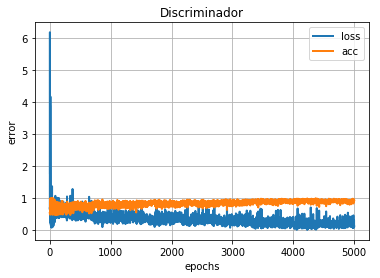

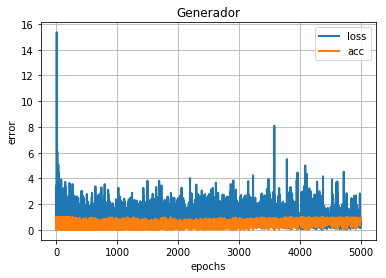

In [17]:
import matplotlib.pyplot as plt
plt.plot(range(len(hist['d'])+1)[1:],hist['d'],label='loss', linewidth=2)


plt.legend(['loss','acc'])
plt.ylabel('error')
plt.xlabel('epochs')
plt.grid(1)
plt.title('Discriminador')
plt.show()

plt.plot(range(len(hist['g'])+1)[1:],hist['g'],label='loss', linewidth=2)


plt.legend(['loss','acc'])
plt.ylabel('error')
plt.xlabel('epochs')
plt.grid(1)
plt.title('Generador')
plt.show()

g) Se generan nuevos datos artificialmente a través del modelo generador G ya entrenado.

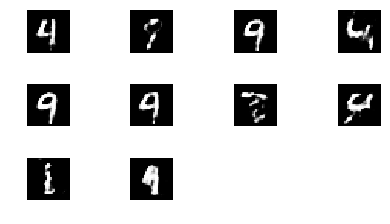

In [18]:
N = 10
noise = np.random.uniform(-1.0, 1.0, size=[N, input_dim]) 
images = G.predict(noise)
import matplotlib.pyplot as plt
for i in range(images.shape[0]):
    plt.subplot(4, 4, i+1)
    image = images[i, :, :, :]
    image = np.reshape(image, [img_rows, img_cols])
    plt.imshow(image, cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()